# CNN

Convolutional Neural Networks for images and signals (feat. TensorFlow and PyTorch)

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import copy
from collections import defaultdict
from matplotlib import pyplot as plt
from tabulate import tabulate
from itertools import islice
from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor, LGBMClassifier

import tensorflow as tf
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision

In [2]:
# Limit TensorFlow GPU memory usage
gpu_devices = tf.config.list_physical_devices('GPU')
if len(gpu_devices) > 0:
    print(f'Detected GPU: {gpu_devices}')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('No GPU detected')

Detected GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Create TensorFlow Board
# %load_ext tensorboard
# %tensorboard --logdir logs/fit --port=6006

## MNIST Dataset

- http://yann.lecun.com/exdb/mnist/
- https://www.kaggle.com/c/digit-recognizer/discussion/61480

In [6]:
mnist_dataset = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist_dataset.load_data()

Test vs train lenght: 60000 vs 10000
Image size: (28, 28)
Image pixel range: 0 - 255
Classes: [0 1 2 3 4 5 6 7 8 9]


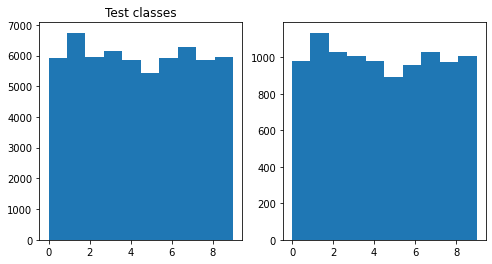

In [7]:
print(f'Test vs train lenght: {len(x_train)} vs {len(x_test)}')
print(f'Image size: {x_train[0].shape}')
print(f'Image pixel range: {x_train[0].min()} - {x_train[0].max()}')
print(f'Classes: {np.unique(y_train)}')
fix, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].hist(y_train)
ax[0].set_title('Train classes')
ax[1].hist(y_test)
ax[0].set_title('Test classes')
_=_

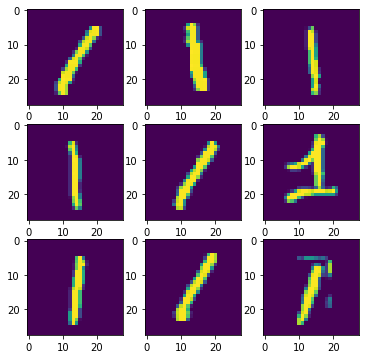

In [8]:
def show_mnist_digit(digit):
    count = 0
    i = 0
    fix, ax = plt.subplots(3, 3, figsize=(6, 6))
    while count < 3*3:
        if y_train[i] == digit:
            ax.ravel()[count].imshow(x_train[i])
            count += 1
        i += 1
        
show_mnist_digit(1)

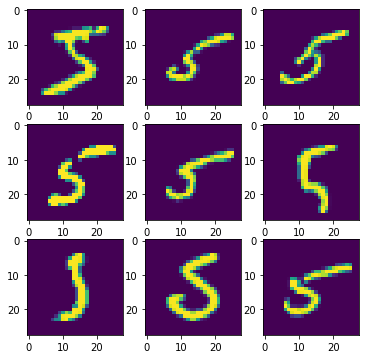

In [9]:
show_mnist_digit(5)

### TF2

In [10]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train[:, :, :, np.newaxis].astype('float32') / 255.0, y_train[:, np.newaxis]))
test_ds = tf.data.Dataset.from_tensor_slices((x_test[:, :, :, np.newaxis].astype('float32') / 255.0, y_test[:, np.newaxis]))

In [11]:
class KerasSequential(tf.keras.Sequential):
    def train_step(self, data):
        X, y = data
        with tf.GradientTape() as tape:
            y_pred = self(X, training=True)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.compiled_metrics.update_state(y, y_pred)
        metric_dict = {m.name: m.result() for m in self.metrics}
        grad_norm = tf.linalg.global_norm(gradients)
        metric_dict.update({'grad_norm': grad_norm})
        return metric_dict

def train_eval_model(model, optimizer, loss, train_ds, test_ds, metrics=tuple(), grad_norm=True,
                     n_epoch=500, n_batch=128,
                     callbacks=None, board_prefix=None, device_name=None):
    with tf.device(device_name):
        k = int(len(train_ds)*0.8)
        train_ds_ = train_ds.take(k).batch(n_batch)
        val_ds_ = train_ds.skip(k).batch(n_batch)
        test_ds = test_ds.batch(n_batch)
        
        model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

        if board_prefix is not None:
            board_name = board_prefix + '_' + dt.datetime.now().strftime('%Y%m%dT%H%M%S')
            callbacks.append(tf.keras.callbacks.TensorBoard(log_dir=Path('logs/tf2/') / board_name))
        train_history = model.fit(
            train_ds_,
            epochs=n_epoch, 
            validation_data=val_ds_,
            verbose=0,
            callbacks=callbacks,
        )

        _ = pd.DataFrame(train_history.history)[['loss', 'val_loss']].plot(title='Training loss', lw=1)
        for metric in metrics:
            _ = pd.DataFrame(train_history.history)[[metric, f'val_{metric}']].plot(title=f'Training {metric}', lw=1)
        if grad_norm:
            _ = pd.DataFrame(train_history.history)[['grad_norm']].plot(title=f'Training gradient norm', lw=1)

        train_results = model.evaluate(train_ds_)
        test_results = model.evaluate(test_ds)
        for i, metric in enumerate(metrics):
            print(f'Train {metric} {train_results[i+1]:.3f}')
            print(f'Test {metric} {test_results[i+1]:.3f}')
            
def get_lr_scheduler(decay_rate, first_epoch=0, last_epoch=1000):
    def sheduler_fun(epoch, lr):
        if (epoch > first_epoch) and (epoch < last_epoch):
            return lr * decay_rate
        else:
            return lr
    return sheduler_fun

#### Feedforward

Instructions for updating:
use `tf.profiler.experimental.stop` instead.
79/79 [==============================] - 0s 1ms/step - loss: 0.0734 - accuracy: 0.9771
Train accuracy 0.998
Test accuracy 0.977
CPU times: user 4min 30s, sys: 1min 20s, total: 5min 50s
Wall time: 3min 44s


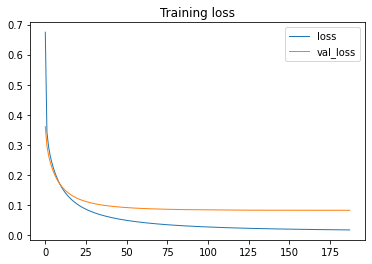

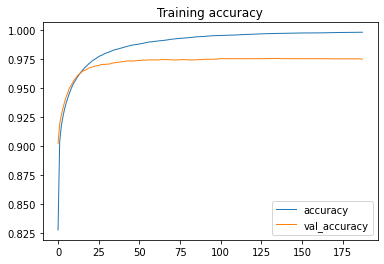

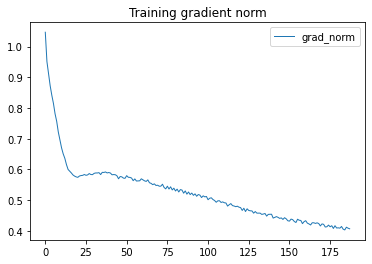

In [10]:
%%time
# Feedforward
model = KerasSequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dense(10),
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.05)

train_eval_model(
    model, optimizer, loss, train_ds, test_ds, metrics=['accuracy'], 
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.99, 10., 200)),
    ],
    board_prefix='mnist_mlp',
)

#### CNN

79/79 [==============================] - 0s 2ms/step - loss: 0.0763 - accuracy: 0.9775
Train accuracy 0.993
Test accuracy 0.978
CPU times: user 2min 58s, sys: 46.5 s, total: 3min 45s
Wall time: 2min 27s


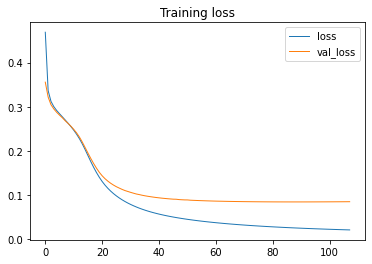

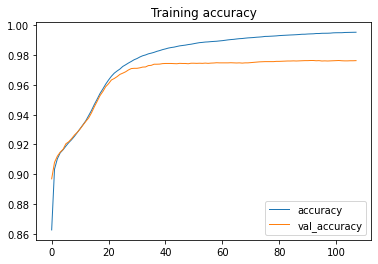

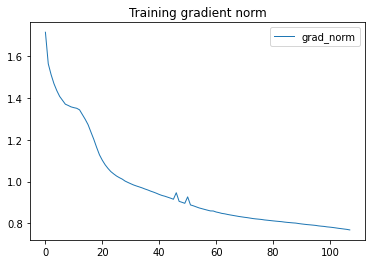

In [11]:
%%time
# CNN 1
model = KerasSequential([
    tf.keras.layers.Conv2D(filters=4, kernel_size=3, strides=1, padding='valid', input_shape=(28, 28, 1)),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10),
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.05)

train_eval_model(
    model, optimizer, loss, train_ds, test_ds, metrics=['accuracy'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.99, 10., 200)),
    ],
    board_prefix='mnist_cnn1',
)

79/79 [==============================] - 0s 2ms/step - loss: 0.0609 - accuracy: 0.9812
Train accuracy 0.994
Test accuracy 0.981
CPU times: user 2min 26s, sys: 32.2 s, total: 2min 58s
Wall time: 2min 1s


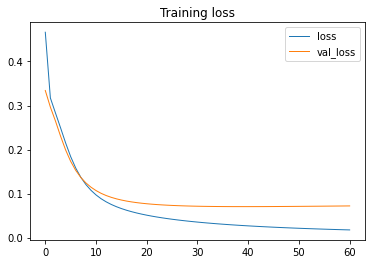

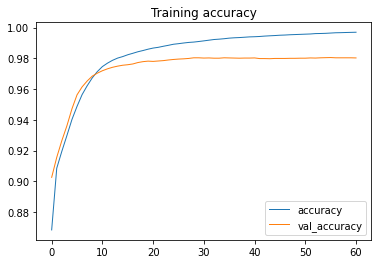

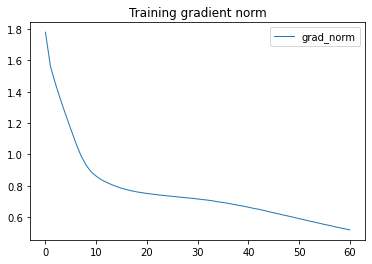

In [12]:
%%time
# CNN 2 (increase number of filters)
model = KerasSequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='valid', input_shape=(28, 28, 1)),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10),
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.05)

train_eval_model(
    model, optimizer, loss, train_ds, test_ds, metrics=['accuracy'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.99, 10., 200)),
    ],
    board_prefix='mnist_cnn2',
)

79/79 [==============================] - 0s 2ms/step - loss: 0.0651 - accuracy: 0.9808
Train accuracy 0.990
Test accuracy 0.981
CPU times: user 1min 34s, sys: 24.6 s, total: 1min 59s
Wall time: 1min 17s


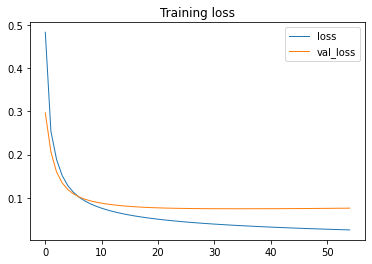

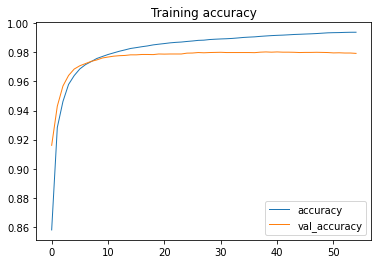

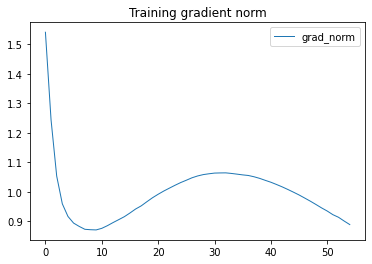

In [13]:
%%time
# CNN 3 (increase kernel size)
model = KerasSequential([
    tf.keras.layers.Conv2D(filters=4, kernel_size=6, strides=1, padding='valid', input_shape=(28, 28, 1)),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10),
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.05)

train_eval_model(
    model, optimizer, loss, train_ds, test_ds, metrics=['accuracy'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.99, 10., 200)),
    ],
    board_prefix='mnist_cnn3',
)

79/79 [==============================] - 0s 2ms/step - loss: 0.0557 - accuracy: 0.9818
Train accuracy 0.994
Test accuracy 0.982
CPU times: user 4min 25s, sys: 59.9 s, total: 5min 25s
Wall time: 3min 38s


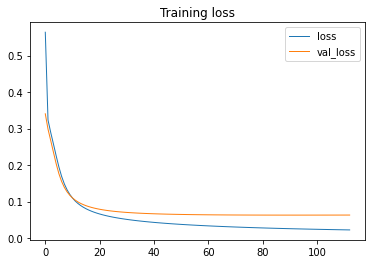

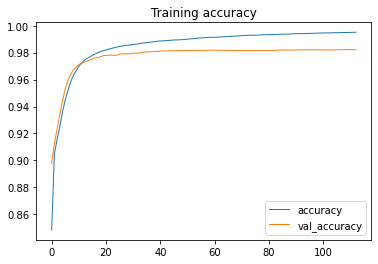

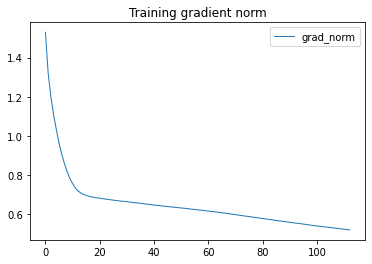

In [14]:
%%time
# CNN 4 (add a pooling layer)
model = KerasSequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='valid', input_shape=(28, 28, 1)),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10),
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.05)

train_eval_model(
    model, optimizer, loss, train_ds, test_ds, metrics=['accuracy'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.99, 10., 200)),
    ],
    board_prefix='mnist_cnn4',
)

79/79 [==============================] - 0s 2ms/step - loss: 0.0603 - accuracy: 0.9824
Train accuracy 0.992
Test accuracy 0.982
CPU times: user 8min 46s, sys: 1min 49s, total: 10min 36s
Wall time: 7min 32s


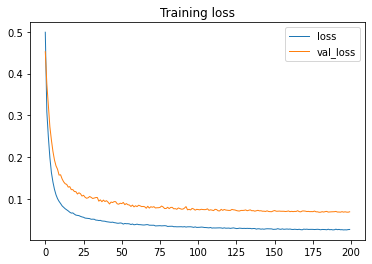

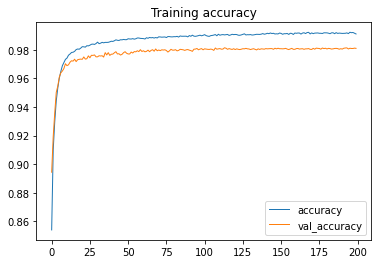

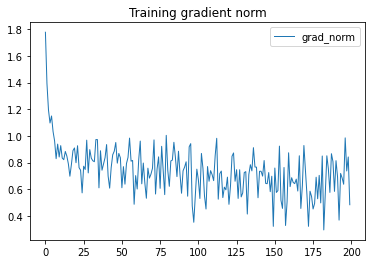

In [15]:
%%time
# CNN 5 (add a dropout layer)
model = KerasSequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='valid', input_shape=(28, 28, 1)),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10),
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.05)

train_eval_model(
    model, optimizer, loss, train_ds, test_ds, metrics=['accuracy'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.99, 10., 200)),
    ],
    board_prefix='mnist_cnn5',
)

Instructions for updating:
use `tf.profiler.experimental.stop` instead.
79/79 [==============================] - 0s 1ms/step - loss: 0.0788 - accuracy: 0.9775
Train accuracy 0.987
Test accuracy 0.978
CPU times: user 1min 26s, sys: 23.9 s, total: 1min 50s
Wall time: 1min 14s


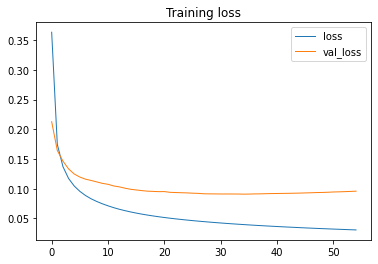

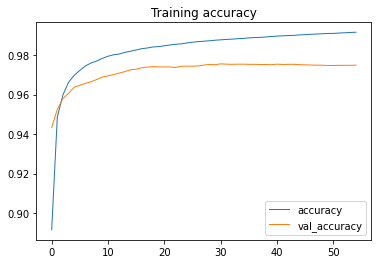

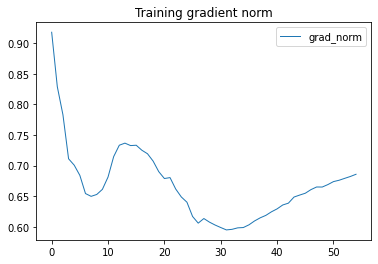

In [7]:
%%time
# CNN 6 (add a batch normalization layer)
model = KerasSequential([
    tf.keras.layers.Conv2D(filters=4, kernel_size=3, strides=1, padding='valid', input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10),
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.05)

train_eval_model(
    model, optimizer, loss, train_ds, test_ds, metrics=['accuracy'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.99, 10., 200)),
    ],
    board_prefix='mnist_cnn6',
)

79/79 [==============================] - 0s 2ms/step - loss: 0.0234 - accuracy: 0.9933
Train accuracy 0.998
Test accuracy 0.993
CPU times: user 2min 55s, sys: 18.6 s, total: 3min 14s
Wall time: 2min 31s


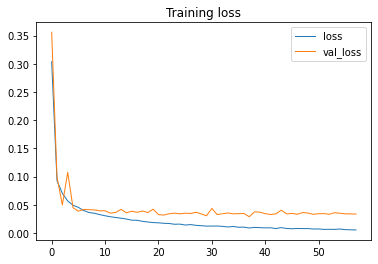

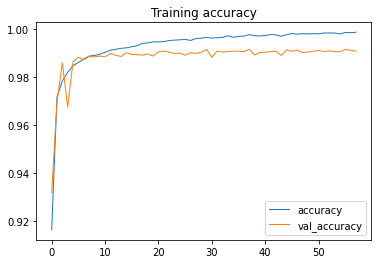

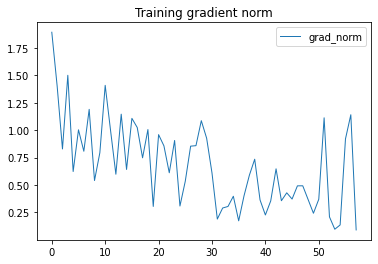

In [13]:
%%time
# CNN 7 (more layers)
model = KerasSequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.05), # rotate between -2*pi*0.05..2*pi*0.05
    tf.keras.layers.ZeroPadding2D(2),  # 28 + 2*2 = 32
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same', input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same'),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10),
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.05)

train_eval_model(
    model, optimizer, loss, train_ds, test_ds, metrics=['accuracy'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.99, 10., 200)),
    ],
    board_prefix='mnist_cnn7',
)

79/79 [==============================] - 0s 2ms/step - loss: 0.0199 - accuracy: 0.9938
Train accuracy 0.998
Test accuracy 0.994
CPU times: user 2min 39s, sys: 19.2 s, total: 2min 59s
Wall time: 2min 5s


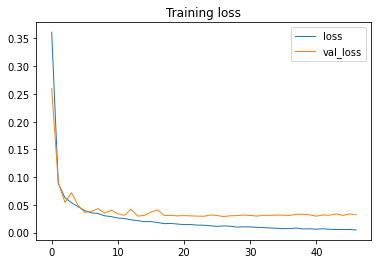

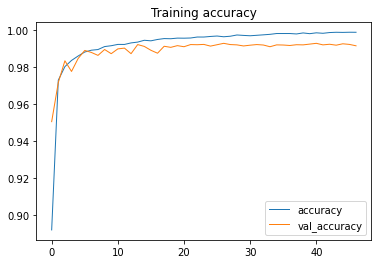

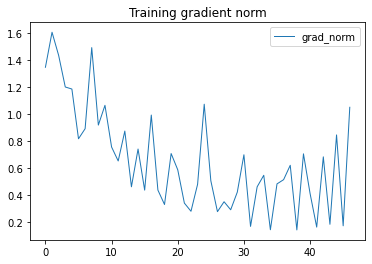

In [20]:
%%time
# CNN 8 (more layers, v.2)
model = KerasSequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.05), # rotate between -2*pi*0.05..2*pi*0.05
    tf.keras.layers.ZeroPadding2D(2),  # 28 + 2*2 = 32
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='same', input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same'),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, kernel_initializer=tf.keras.initializers.constant(0)),
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.05)

train_eval_model(
    model, optimizer, loss, train_ds, test_ds, metrics=['accuracy'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.99, 10., 200)),
    ],
    board_prefix='mnist_cnn8',
)

#### CNN + Deconvolution (U-Net)
- https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py
- https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277
- https://arxiv.org/abs/1505.04597

In [ ]:
%%time
# U-NET
# TODO: Finish
model = KerasSequential([
    # --- Preprocess
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.05), # rotate between -2*pi*0.05..2*pi*0.05
    tf.keras.layers.ZeroPadding2D(2),  # 28 + 2*2 = 32
    # --- Downsample
    tf.keras.layers.Conv2D(filters=16, kernel_size=2, strides=1, padding='same', input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, strides=1, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=2, strides=1, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2),
    # --- Upsample
    tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=2, strides=2, padding='same')
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=2, strides=2, padding='same')
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    # --- Output
    tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=2, strides=2, padding='same')
])
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.SGD(0.05)

train_eval_model(
    model, optimizer, loss, train_ds, test_ds, metrics=['accuracy'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        tf.keras.callbacks.LearningRateScheduler(get_lr_scheduler(0.99, 10., 200)),
    ],
    board_prefix='mnist_unet',
)

## PyTorch

In [75]:
class PrepareData(Dataset):
    def __init__(self, X, y, transform=None, device=None):
        self.X = torch.from_numpy(X[:, np.newaxis, :, :]).float()
#         self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()
        self.transform = transform
        self.device = device

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X, y = self.X[idx], self.y[idx]
        if self.transform is not None:
            X = self.transform(X)
        if self.device is not None:
            X, y = X.to(self.device), y.to(self.device)
        return X, y
    
    def to(self, device):
        self.device = device
#         self.X = self.X.to(device)
#         self.y = self.y.to(device)
    

ds_train = PrepareData(
    x_train / 255., y_train, 
    torchvision.transforms.Compose([
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.RandomRotation(.05 * 360.),  # rotate between -2*pi*0.05..2*pi*0.05)
        torchvision.transforms.ToTensor(),
    ]),
)
ds_train = PrepareData(x_train / 255., y_train)
ds_test = PrepareData(x_test / 255., y_test)

In [73]:
class TorchLimitedScheduler:
    def __init__(self, scheduler, first_epoch=0, last_epoch=1000):
        self.scheduler = scheduler
        self.first_epoch = first_epoch
        self.last_epoch = last_epoch
        self.current_epoch = 0

    def step(self):
        if (self.current_epoch >= self.first_epoch) and (self.current_epoch < self.last_epoch):
            self.scheduler.step()
        self.current_epoch += 1

def eval_loss_nograd(model, loss_func, loader):
    with torch.no_grad():
        loss_c = 0
        for X_batch, y_batch in loader:
            loss = loss_func(model(X_batch), y_batch)
            loss_c += loss.item()
        return loss_c / len(loader) 
    
def torch_accuracy_score(predicted, labels):
    predicted = torch.argmax(predicted.data, 1)
    n_correct = (predicted == labels).sum() / float(len(predicted))
    return n_correct

def torch_mae(predicted, labels):
    return (predicted - labels).abs().sum() / float(len(predicted))

torch_metrics = {
    'accuracy': torch_accuracy_score,
    'mae': torch_mae,
}

def train_eval_model(model, optimizer, loss_func, train_ds, test_ds, scheduler=None, early_stopping=None,
                     device_name='auto', metrics=tuple(), board_prefix=None,
                     n_epoch=1000, n_batch=128):
    if device_name == 'auto':
        device_name = 'cuda' if torch.cuda.is_available() else 'gpu'
    device = torch.device(device_name)
    model.to(device)
    train_ds.to(device)
    test_ds.to(device)
    print(f'Running on {device_name}...')

    train_size = int(len(train_ds)*0.8)
    train_ds, val_ds = torch.utils.data.random_split(train_ds, [train_size, len(train_ds)-train_size])
    train_loader = DataLoader(train_ds, batch_size=n_batch, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=n_batch, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=n_batch, shuffle=True)
    
    if board_prefix is not None:
        board_name = board_prefix + '_' + dt.datetime.now().strftime('%Y%m%dT%H%M%S')
        writer = SummaryWriter(log_dir=Path('logs/torch/') / board_name)
    else:
        writer = None
 
    train_history = defaultdict(list)
    min_val_loss = None
    steps_without_improvement = 0
    for epoch in range(n_epoch):
        loss_c = 0
        grad_norm_c = 0
        for X_train_batch, y_train_batch in train_loader:
            optimizer.zero_grad()
            loss = loss_func(model(X_train_batch), y_train_batch)
            loss.backward()
            optimizer.step()
            loss_c += loss.item()
            for p in islice(model.parameters(), 5):
                grad_norm_c += float(torch.norm(p.grad))
        train_history['loss'].append(loss_c/len(train_loader))
        train_history['grad_norm'].append(grad_norm_c/len(train_loader))

        train_history['val_loss'].append(eval_loss_nograd(model, loss_func, val_loader))
        for metric in metrics:
            train_history[metric].append(eval_loss_nograd(model, torch_metrics[metric], train_loader))
            train_history[f'val_{metric}'].append(eval_loss_nograd(model, torch_metrics[metric], val_loader))
            
        if early_stopping is not None:
            if (min_val_loss is None) or (train_history['val_loss'][-1] < min_val_loss):
                min_val_loss = train_history['val_loss'][-1]
                best_state = copy.deepcopy(model.state_dict())
                steps_without_improvement = 0
            else:
                steps_without_improvement += 1
                if steps_without_improvement >= early_stopping:
                    model.load_state_dict(best_state)
                    break
        
        if writer is not None:
            for k, v in train_history.items():
                k_ = f'{k[4:]}/val' if k.startswith('val_') else f'{k}/train'
                writer.add_scalar(k_, v[-1], epoch)
                    
        if scheduler is not None:
            scheduler.step()

    _ = pd.DataFrame(train_history)[['loss', 'val_loss']].plot(title='Training loss', lw=1, alpha=0.8)

    for metric in metrics:
        _ = pd.DataFrame(train_history)[[metric, f'val_{metric}']].plot(title=f'Training {metric}', lw=1, alpha=0.8)
        train_metric = eval_loss_nograd(model, torch_metrics[metric], train_loader)
        test_metric = eval_loss_nograd(model, torch_metrics[metric], test_loader)
        print(f'Train {metric} {train_metric:.3f}')
        print(f'Test {metric}  {test_metric:.3f}')
    
    _ = pd.DataFrame(train_history)[['grad_norm']].plot(title='Training gradient norm', lw=1, alpha=0.8)

#### Feedforward

Running on cuda...
Train accuracy 0.997
Test accuracy  0.976
CPU times: user 4min 48s, sys: 1.61 s, total: 4min 50s
Wall time: 4min 20s


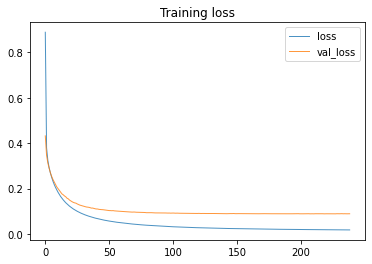

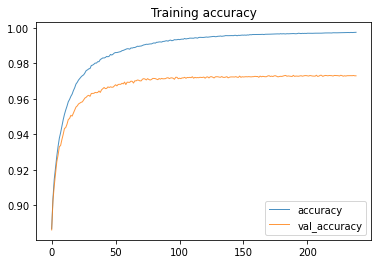

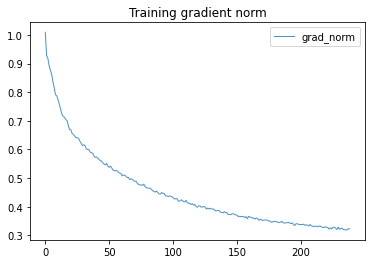

In [48]:
%%time
# Feedforward
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(28*28, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 10),
)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
scheduler = TorchLimitedScheduler(
    torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99),
    first_epoch=10, last_epoch=200,
)
loss_func = torch.nn.CrossEntropyLoss()
train_eval_model(
    model, optimizer, loss_func, ds_train, ds_test, scheduler=scheduler, early_stopping=20,
    metrics=['accuracy'],
    board_prefix='mnist_mlp',
)

#### CNN

Running on cuda...
Train accuracy 0.999
Test accuracy  0.992
CPU times: user 3min 31s, sys: 237 ms, total: 3min 32s
Wall time: 3min 28s


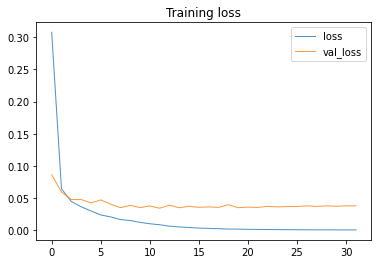

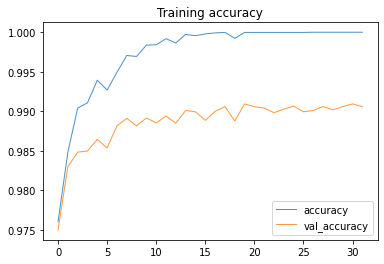

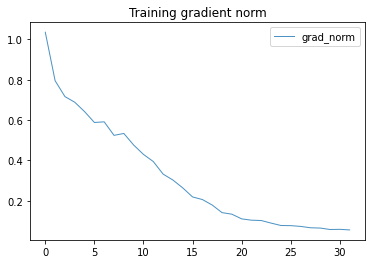

In [76]:
%%time
# CNN 7
model = torch.nn.Sequential(
#     torchvision.transforms.RandomRotation(.05 * 360.),  # moved to the dataset class
    torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=2),
    torch.nn.BatchNorm2d(32),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=2),
    torch.nn.BatchNorm2d(32),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=2),
    torch.nn.BatchNorm2d(32),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=2),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Flatten(),
    torch.nn.Linear(288, 10),
)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
scheduler = TorchLimitedScheduler(
    torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99),
    first_epoch=10, last_epoch=200,
)
loss_func = torch.nn.CrossEntropyLoss()
train_eval_model(
    model, optimizer, loss_func, ds_train, ds_test, scheduler=scheduler, early_stopping=20,
    metrics=['accuracy'],
    board_prefix='mnist_cnn7',
)